# Setup

In [1]:
import pickle
import tensorflow as tf

from util import *
from biomedical_qa.inference.inference import Inferrer
from biomedical_qa.sampling.squad import SQuADSampler

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
inferrer = Inferrer("../model_checkpoints/bioasq_finetune_dropout04/config.pickle",
                    ["cpu:0"], 10)

Loading Model...
Restoring Weights...
Using weights: ../model_checkpoints/bioasq_finetune_dropout04/final_model.tf


In [3]:
vocab = inferrer.model.embedder.vocab
rev_vocab = [""] * len(vocab)
for w, i in vocab.items():
    rev_vocab[i] = w

In [4]:
sampler = SQuADSampler("../data/BioASQ_squad", ["dev.json"], 16, vocab=vocab, shuffle=False)

# Run Model

In [5]:
predictions = inferrer.get_predictions(sampler)

# Factoid Analysis

In [6]:
factoid_predictions = [p for p in predictions.values() if p.question.q_type == "factoid"]

In [7]:
for prediction in factoid_predictions:
    
    print("Question:")
    print(prediction.question.question_json["question"])
    print("Answers:")
    print_list(maybe_flatten_list(prediction.question.question_json["original_answers"]))
    print("Predicted Answers:")
    print_list(prediction.answer_strings[:5])
    print()

Question:
which pituitary adenoma is common cause of infertility is women?
Answers:
 * prolactinoma
Predicted Answers:
 * pituitary
 * pituitary adenoma
 * gonadotroph
 * prolactin
 * galactorrhea

Question:
the antibodies mk-3475 and ct-011 have shown promising results in treating malignancies. which protein are they targeting?
Answers:
 * PD-1
Predicted Answers:
 * -PD-1 antibody
 * anti-PD-1 antibody
 * -PD-1
 * CT-011) PD-1
 * an anti-PD-1 antibody

Question:
what is the inheritance pattern of catecholaminergic polymorphic ventricular tachycardia (cpvt) caused by ryr2 mutations?
Answers:
 * autosomal dominant
Predicted Answers:
 * autosomal dominant
 * high penetrance
 * autosomal dominant or recessive
 * autosomal dominant or recessive, usually with high penetrance
 * sudden death

Question:
what is the effect of the absence of saccharomyces cerevisiae rrm3p?
Answers:
 * Lack of the yeast Rrm3p DNA helicase causes replication defects at multiple sites within ribosomal DNA (rDNA), 

In [8]:
def is_correct_lenient(prediction):
    correct_answers = maybe_flatten_list(prediction.question.question_json["original_answers"])
    for correct_answer in correct_answers:
        for predicted_answer in prediction.answer_strings:
            if correct_answer.lower().strip() == predicted_answer.lower().strip():
                return True
    return False

In [9]:
correct_predictions = [p for p in factoid_predictions if is_correct_lenient(p)]
incorrect_predictions = [p for p in factoid_predictions if not is_correct_lenient(p)]

print("Correct: %d, Incorrect: %d" % (len(correct_predictions), len(incorrect_predictions)))

Correct: 27, Incorrect: 16


## Pointer Visualization (Incorrect Answer)

In [10]:
prediction = incorrect_predictions[0]
tokens = [rev_vocab[w] for w in prediction.question.context]

print("Id:")
print("  " + prediction.question.id)
print("Question:")
print("  " + prediction.question.question_json["question"])
print("Answers:")
print_list(maybe_flatten_list(prediction.question.question_json["original_answers"]))
print("Predicted Answers:")
print_list(zip(prediction.answer_strings[:5], prediction.probs[:5]))

Id:
  514a51c2d24251bc0500005c
Question:
  which pituitary adenoma is common cause of infertility is women?
Answers:
 * prolactinoma
Predicted Answers:
 * ('pituitary', 0.95766723)
 * ('pituitary adenoma', 0.015600207)
 * ('gonadotroph', 0.0091248509)
 * ('prolactin', 0.0047832113)
 * ('galactorrhea', 0.0038361766)


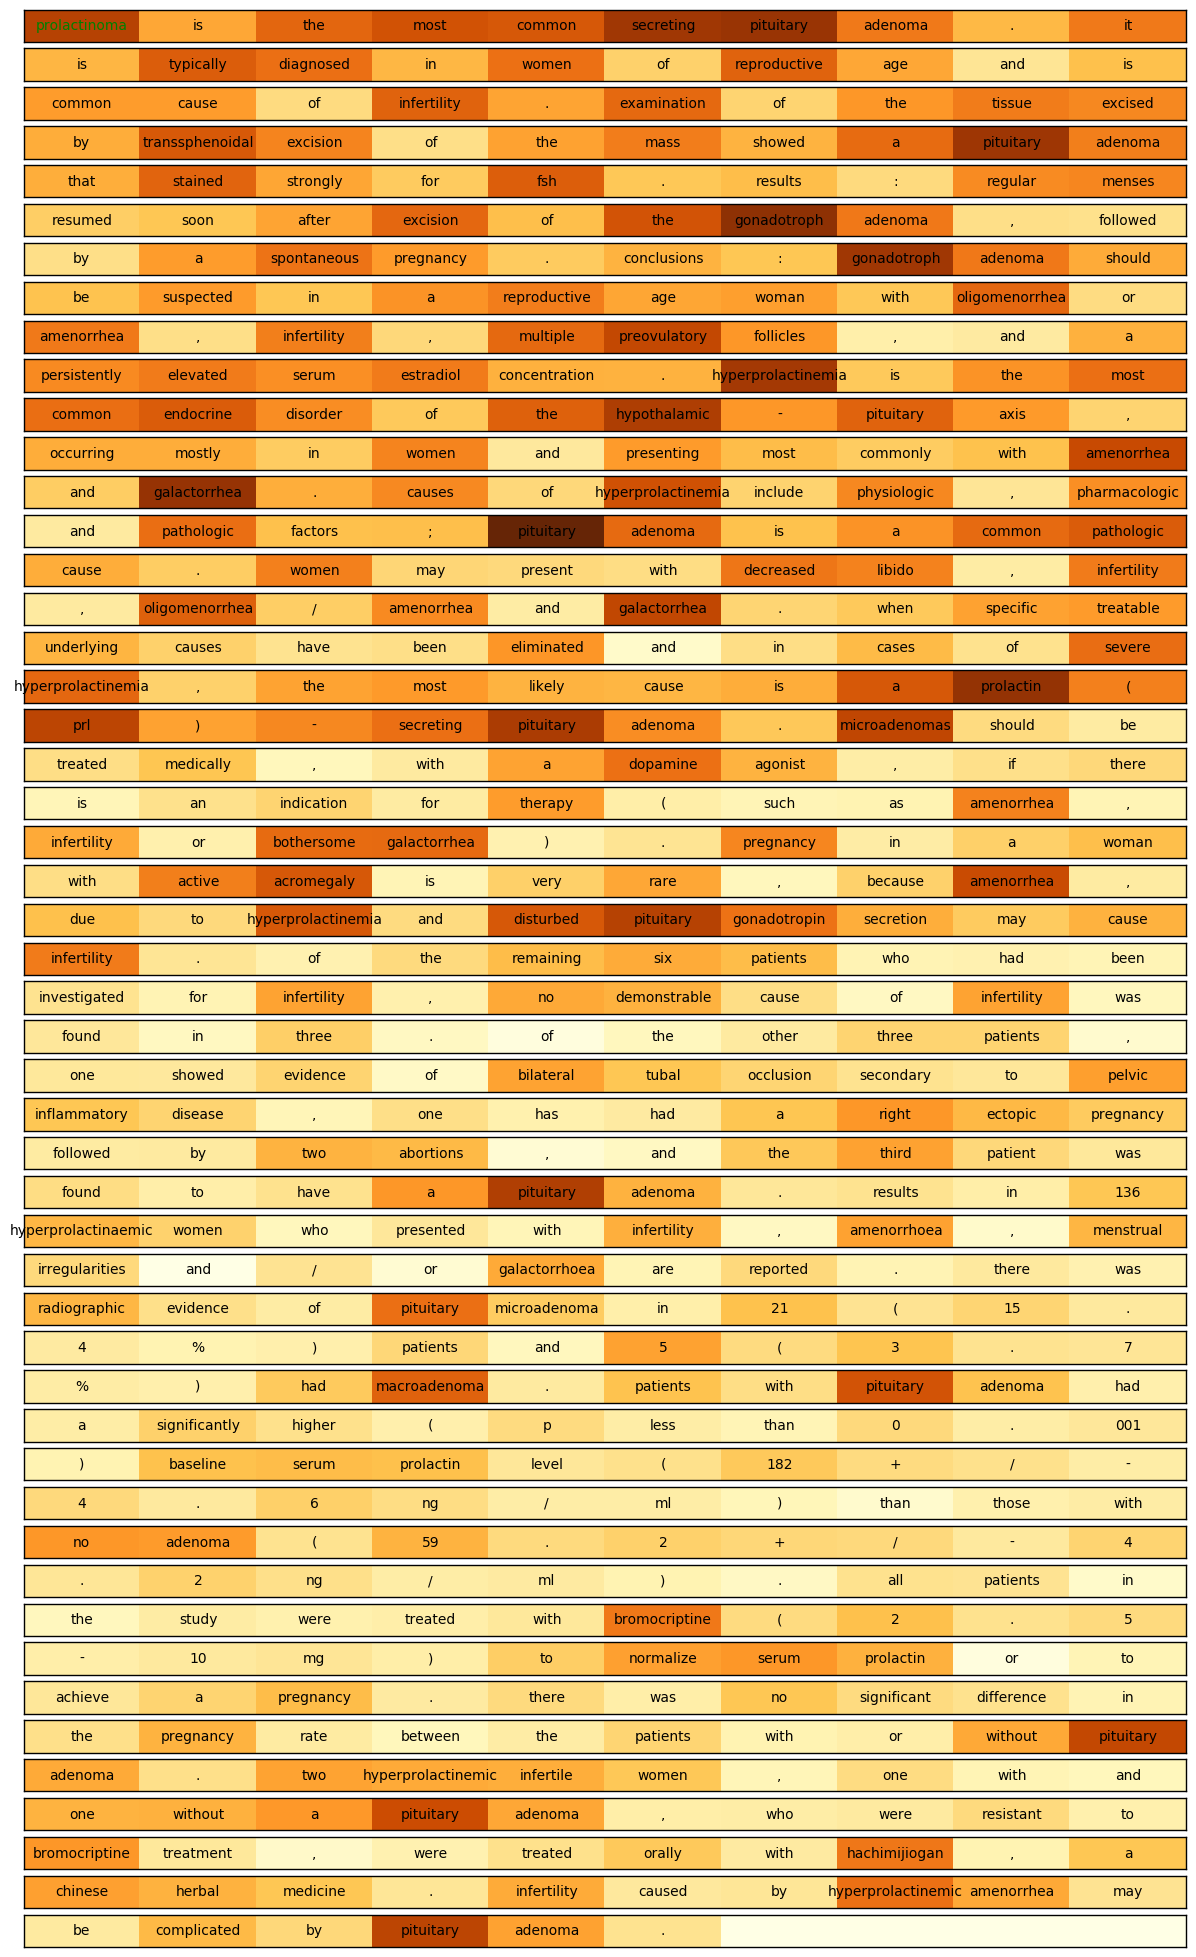

In [11]:
correct_tokens = find_correct_tokens(prediction.question)

text_heatmap(tokens, prediction.start_scores, correct_tokens)

In [12]:
# TODO
#start_token_mask = np.zeros(len(tokens), dtype=np.bool)
#start_token_mask[prediction.starts[0]] = True

#text_heatmap(tokens, prediction.end_scores[0], start_token_mask)

In [13]:
prediction.end_scores.shape

(697,)